In [4]:
import os
os.getcwd()
os.chdir('/work')
print(os.getcwd())
current_folder = globals()['_dh'][0]
import pathlib
import sys
del sys.argv[1]
print(sys.path)
from sty import fg, bg, rs, ef

from experiments.transformations.analysis.activation_distance.activation_distance_utils import *

/work
['/work/code/experiments/transformations/analysis', '/work/scripts', '/work/code', '/work/code/experiments/transformations/analysis', '/src', '/src/models', '/work/code/ML_framework', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/thedude/.ipython']


In [36]:
import matplotlib.pyplot as plt
import seaborn as sn
from ML_framework.distance_activation import DistanceActivation
from generate_datasets.generators.extension_generators import *
from torch.utils.data import DataLoader
import os
from experiments.transformations.transf_utils import classes_sets, exp_categorization_task, get_transforms
from experiments.transformations.transf_utils import get_fulltrain_strings
##

dataset_name = 'ShapeNet'

import torchvision
def change_transformation_dataset(dataset, transformations):
    # num_v = 50 if 'v' in transformations else 1
    add_PIL_transforms, add_T_transforms = get_transforms(transformations, info=False)
    dataset.transform = torchvision.transforms.Compose([*add_PIL_transforms, torchvision.transforms.ToTensor(), *add_T_transforms])
    normalize = torchvision.transforms.Normalize(mean=stats['mean'],
                                                         std=stats['std'])
    dataset.transform.transforms += [normalize]


def get_exp(max_objs):
    shared_args = lambda: dict(seed=1, project_name='Transformations', use_weblog=0, batch_size=64, max_epochs=-1 if torch.cuda.is_available() else 2, num_viewpoints_train=1, use_mat=0, max_objs_per_class_train=max_objs)
    exp = exp_categorization_task(**shared_args(),
                                  classes_set='set2',
                                  network_name='vgg11bn',
                                  use_device_num=3,
                                  verbose=False)

    name_folder = f'ShapeNet2DFull{"Nomat" if not exp.use_mat else ""}'

    add_PIL_transforms, add_T_transforms = get_transforms('', info=False)
    args = dict(name_generator=f"train {exp.classes_set}",
                add_PIL_transforms=add_PIL_transforms, 
                add_tensor_transforms=add_T_transforms, 
                save_stats_file=None, 
                stats=stats,
                num_objects_per_class=exp.max_objs_per_class_train,
                name_classes=classes_sets[exp.classes_set], 
                num_viewpoints_per_object=exp.num_viewpoints_train,
                root=f"./data/ShapeNet2D/{name_folder}/train")
                #save_load_samples_filename='./train_set2_numO3_numV1_S1.s')
    dataset = add_compute_stats(SubclassImageFolder)(**args)
    loader = DataLoader(dataset, batch_size=exp.batch_size, shuffle=False, num_workers=0, timeout=0, pin_memory=True)

    return exp, dataset, loader
stats = {'mean': [0.06229676, 0.0607271, 0.05646703], 'std': [0.14454809, 0.14061172, 0.12994126]}

def get_net(pt_transform, pt_objs=None):
    pt_num_v = 50 if 'v' in pt_transform else 1

    if pt_transform == 'vanilla':
        exp.pretraining = 'vanilla'
        exp.network_name = network_name
        net = exp.get_net(10)
        net_name = 'vanilla'
        folder_output = 'others'

    elif pt_transform == 'ImageNet':
        exp.network_name = 'vgg11bn'
        exp.pretraining = './models/ptImageNet/vgg11bn.pt'
        net = exp.get_net(1000)
        net_name = 'ImageNet'
        folder_output = 'others'
    else:
        _, exp.pretraining, _ = get_fulltrain_strings(pt_transform, pt_objs, pt_num_v, class_set='set1', mat=0, network_name=network_name, seed=1)
        net_name = os.path.splitext(os.path.basename(exp.pretraining))
        print(net_name)
#         exp.pretraining = 'vanilla'
        exp.network_name = network_name
        folder_output = 'fulltrain'
        net = exp.get_net(new_num_classes=10)
        
        if network_name == 'relationNet':
            net = net.backbone
#     print(net)

    net.eval()
    return net


In [13]:
class SanityCheck(DistanceActivation):
    def get_base_and_other_canvasses(self, class_num, name_class):
        pass


exp, dataset, loader = get_exp(3)

Using cuda - you are probably on the server
Running experiment in SCRIPT mode. Command line arguments will have the precedence over keywords arguments.
Device Name: [GeForce RTX 3090] - Selected device num: 3

**LIST_TAGS**:
['ptvanilla', 'bkbnvanilla']
***PARAMS***
	add_cat_module : False
	additional_tags : None
	backbone_name : None
	batch_size : 64
	classes_set : set2
	device_name : GeForce RTX 3090
	diff_classes_set : None
	do_train : True
	force_cuda : None
	freeze_all_but_last : False
	freeze_backbone : False
	learning_rate : None
	max_epochs : -1
	max_iterations : -1
	max_objs_per_class_test : None
	max_objs_per_class_train : 3
	model_output_filename : None
	network_name : vgg11bn
	num_iterations_testing : -1
	num_runs : 1
	num_viewpoints_test : None
	num_viewpoints_train : 1
	output_filename : None
	patience_stagnation : -1
	pretraining : vanilla
	pretraining_backbone : vanilla
	project_name : Transformations
	scramble_fc : 0
	seed : 1
	stop_when_train_acc_is : -1
	transformati

In [44]:

## EVALUATE IMAGENET
def do_it(pt_transform, pt_name, pt_obj=None):
    change_transformation_dataset(dataset, pt_transform)
    for idx, data in enumerate(loader):
        img_set1, lb, lo = data

    for idx, data in enumerate(loader):
        img_set2, lb, lo = data


    net = get_net(pt_name, pt_obj)

    sc = SanityCheck(net, distance='cossim')
    i = 0
    all_cossim = np.zeros((30, 30))
    for i in range(30):
        cossim_net, cossim_images,  p = sc.get_cosine_similarity_from_images(img_set1[i], img_set2)
        all_cossim[i, :] = cossim_net[sc.all_layers_name[-1]]

#     for i in range(30):
#         for j in range(30):
#             cc = torch.cat((img_set1[i].unsqueeze(0), img_set2[j].unsqueeze(0)))
#           #  print(cc.shape)
#             out = net(cc.cuda())
#             all_cossim[i][j] = 1 - torch.mean(out, dim=1)
    return all_cossim


In [59]:
transf = 'v'


network_name = 'vgg11bn'
all_cossim_im = do_it(transf,'ImageNet')

network_name = 'vgg11bn'
all_cossim_superv = do_it(transf, transf, 500)

network_name = 'relationNet'
all_cossim_relnet = do_it(transf, transf, 500)


Loading.. full model from ./models/ptImageNet/vgg11bn.pt... Done.
('FULLTRAIN_Tv_objs500_vp50_mat0_trset1_S1', '.pt')
Loading.. full model from ./models/transformations//ShapeNet/vgg11bn/fulltrain/FULLTRAIN_Tv_objs500_vp50_mat0_trset1_S1.pt... Done.
('FULLTRAIN_Tv_objs500_vp50_mat0_trset1_S1', '.pt')
Loading.. full model from ./models/transformations//ShapeNet/relationNet/fulltrain/FULLTRAIN_Tv_objs500_vp50_mat0_trset1_S1.pt... Done.


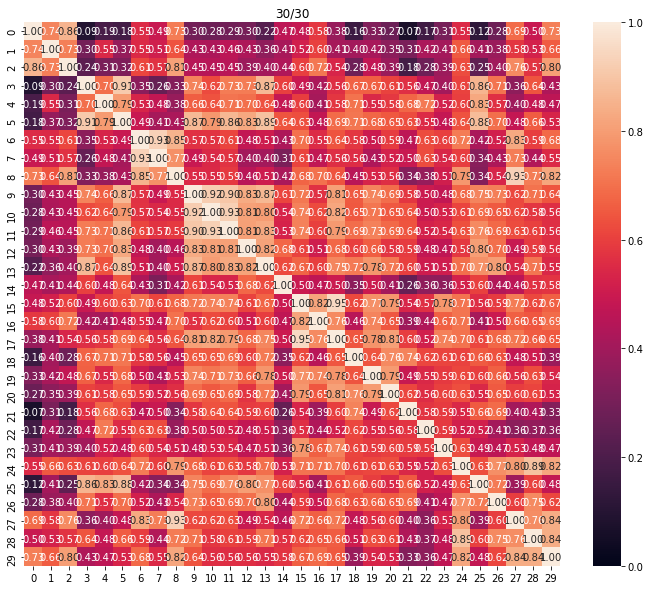

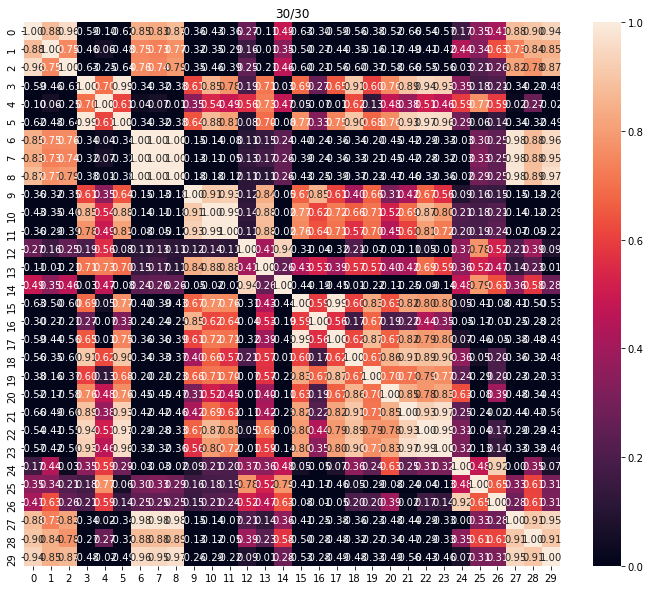

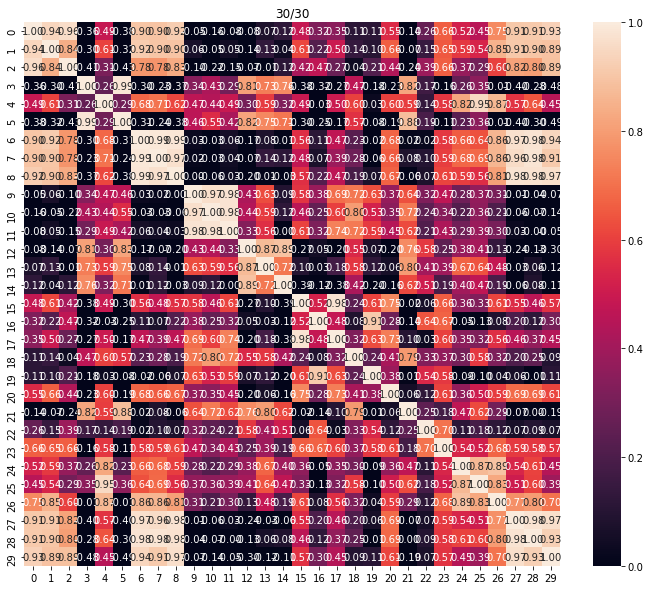

In [60]:

def heatmap(v):
    acc = np.sum(np.argmax(v, 0) == np.arange(30))
    plt.close('all')
    figure = plt.figure(figsize=(12, 10))
    sn.heatmap(v, annot=True, fmt=".2f", annot_kws={"size": 10}, vmin=0, vmax=1)  # font size
    np.sum(np.argmax(all_cossim_im, 0) == np.arange(30))
#     plt.title(f'IMAGENET acc {acc_im}/30')
    plt.title(f'{acc}/30')
    plt.show()

# ##
heatmap(all_cossim_im)
heatmap(all_cossim_superv)
heatmap(all_cossim_relnet)
